In [3]:
import emopt
from emopt.misc import NOT_PARALLEL, run_on_master
from emopt.experimental.adjoint_method import TopologyPNF2D
from emopt.adjoint_method import AdjointMethodPNF2D
from emopt.experimental.fdfd import FDFD_TM
from emopt.experimental.grid import TopologyMaterial2D
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [4]:
PLANAR = False
VOL_PEN = 0.

In [5]:
class TopologyAM(TopologyPNF2D):
    def __init__(self, sim, mode_match, mm_line, domain=None, update_mu=False, eps_bounds=None, mu_bounds=None, planar=False, vol_penalty=0):
        super().__init__(sim, domain=domain, update_mu=update_mu, eps_bounds=eps_bounds, mu_bounds=mu_bounds, planar=planar, vol_penalty=vol_penalty)
        self.mode_match = mode_match
        self.current_fom = 0.0
        self.mm_line = mm_line

    @run_on_master
    def calc_f(self, sim, params):
        Hz, Ex, Ey = sim.saved_fields[0]
        self.mode_match.compute(Hz=Hz, Ex=Ex, Ey=Ey)
        fom = -self.mode_match.get_mode_match_forward(1.0)
        return fom

    @run_on_master
    def calc_dfdx(self, sim, params):
        dFdHz = np.zeros([sim.M, sim.N], dtype=np.complex128)
        dFdEx = np.zeros([sim.M, sim.N], dtype=np.complex128)
        dFdEy = np.zeros([sim.M, sim.N], dtype=np.complex128)

        # Get the fields which were recorded
        Hz, Ex, Ey = sim.saved_fields[0]

        self.mode_match.compute(Hz=Hz, Ex=Ex, Ey=Ey)

        dFdHz[self.mm_line.j, self.mm_line.k] = -self.mode_match.get_dFdHz()
        dFdEx[self.mm_line.j, self.mm_line.k] = -self.mode_match.get_dFdEx()
        dFdEy[self.mm_line.j, self.mm_line.k] = -self.mode_match.get_dFdEy()

        return (dFdHz, dFdEx, dFdEy)

In [6]:
def plot_update(params, fom_list, penalty_list, sim, am):
    print('Finished iteration %d' % (len(fom_list)+1))
    total_fom = am.calc_fom(sim, params)
    current_penalty = am.current_vol_penalty
    current_fom = -1*(total_fom - current_penalty)
    penalty_list.append(current_penalty)
    fom_list.append(current_fom)

    Hz, Ex, Ey = sim.saved_fields[1]
    eps = sim.eps.get_values_in(sim.field_domains[1])

    foms = {'Mode Match' : fom_list, 'Vol. Penalty' : penalty_list}
    emopt.io.plot_iteration(np.flipud(Hz.real), np.flipud(eps.real), sim.Xreal,
                            sim.Yreal, foms, fname='current_result_planar{}_volpen{}.pdf'.format(PLANAR, VOL_PEN),
                            dark=False)

    #data = {}
    #data['params'] = params
    #data['foms'] = fom_list

    #i = len(fom_list)
    #fname = 'data/topology_results'
    #emopt.io.save_results(fname, data)

In [7]:
# define the system parameters

dx = 0.03
dy = dx

pml_w = 13*dx
wavelength = 1.31
X = 12.0 + 2 * pml_w
Y = 9.0 + 2 * pml_w

# create the simulation object.
# TM => Hz, Ex, Ey
sim = FDFD_TM(X, Y, dx, dy, wavelength)

# Get the actual width and height
X = sim.X
Y = sim.Y
M = sim.M
N = sim.N

sim.w_pml = [pml_w, pml_w, pml_w, pml_w]
w_pml = sim.w_pml[0] # PML width which is the same on all boundaries by default

In [8]:
# Define the structure

n_si = 3.0 # effective index of silicon, since we are using 2D simulation
n_sio2 = 1.44
eps_si = n_si**2
eps_clad = n_sio2**2

in_wg = emopt.grid.Rectangle(0.0, Y/2.0, 10.0, 0.5)
in_wg.layer = 2
in_wg.material_value = eps_si

out_wg1 = emopt.grid.Rectangle(X, Y/2.0+1.0, 10.0, 0.5)
out_wg1.layer = 2
out_wg1.material_value = eps_si

out_wg2 = emopt.grid.Rectangle(X, Y/2.0-1.0, 10.0, 0.5)
out_wg2.layer = 2
out_wg2.material_value = eps_si

init_rect = emopt.grid.Rectangle(X/2, Y/2, 4.0, 2.8)
init_rect.layer = 1
init_rect.material_value = eps_si/2.

bg = emopt.grid.Rectangle(X/2, Y/2, 2*X, 2*Y)
bg.layer = 3
bg.material_value = eps_clad

eps = emopt.grid.StructuredMaterial2D(X, Y, dx, dy)

eps.add_primitive(in_wg)
eps.add_primitive(out_wg1)
eps.add_primitive(out_wg2)
eps.add_primitive(init_rect)
eps.add_primitive(bg)

optdomain = emopt.misc.DomainCoordinates(0.5*X-2.1, 0.5*X+2.1,
                                            0.5*Y-1.5, 0.5*Y+1.5,
                                            0.0, 0.0, dx, dy, 1.0)

eps_top = TopologyMaterial2D(eps, optdomain) # set up the topology material
                                                # optdomain defines optimizable
                                                # domain. It is initialized from
                                                # the structured material object.

# set up the magnetic permeability -- just 1.0 everywhere
mu = emopt.grid.ConstantMaterial2D(1.0)

# add the materials and build the system
sim.set_materials(eps_top, mu)

In [9]:
# Setup the sources

w_src= 3.5

# place the source in the simulation domain
src_line = emopt.misc.DomainCoordinates(w_pml+2*dx, w_pml+2*dx, Y/2-w_src/2,
                                Y/2+w_src/2, 0, 0, dx, dy, 1.0)

# Setup the mode solver.
mode = emopt.modes.ModeTM(wavelength, eps, mu, src_line, n0=n_si, neigs=4)

if(NOT_PARALLEL):
    print('Generating mode data...')

mode.build()
mode.solve()

# at this point we have found the modes but we dont know which mode is the
# one we fundamental mode.  We have a way to determine this, however
mindex = mode.find_mode_index(0)

# set the current sources using the mode solver object
sim.set_sources(mode, src_line, mindex)


Generating mode data...


In [10]:
# Setup the field domains for FOM calc
full_field = emopt.misc.DomainCoordinates(w_pml, X-w_pml, w_pml, Y-w_pml, 0.0, 0.0,
                                            dx, dy, 1.0)
w_mode = 6.0

# place the source in the simulation domain
mode_line = emopt.misc.DomainCoordinates(X-(w_pml+2*dx), X-(w_pml+2*dx), Y/2-w_mode/2,
                                Y/2+w_mode/2, 0, 0, dx, dy, 1.0)

# Setup the mode solver.
mode_fom = emopt.modes.ModeTM(wavelength, eps, mu, mode_line, n0=n_si, neigs=4)

if(NOT_PARALLEL):
    print('Generating mode data...')

mode_fom.build()
mode_fom.solve()

Hzm = mode_fom.get_field_interp(0, 'Hz')
Exm = mode_fom.get_field_interp(0, 'Ex')
Eym = mode_fom.get_field_interp(0, 'Ey')
if not NOT_PARALLEL:
    Hzm = emopt.misc.MathDummy()
    Exm = emopt.misc.MathDummy()
    Eym = emopt.misc.MathDummy()

mode_match = emopt.fomutils.ModeMatch([1,0,0], sim.dy, Hzm=Hzm, Exm=Exm, Eym=Eym)

sim.field_domains = [mode_line, full_field]

Generating mode data...


In [11]:
# Setup the optimization

# define the topology optimization object
am = TopologyAM(sim,
                mode_match,
                mode_line,
                domain=optdomain,
                update_mu=False,
                eps_bounds=[eps_clad, eps_si],
                planar=PLANAR,
                vol_penalty=VOL_PEN)

# get the design parameters (built in)
design_params = am.get_params(squish=0.02)
am.update_system(design_params)

# do a quick gradient check if desired
# am.check_gradient(design_params, indices=np.arange(100)[::2], fd_step=1e-4)

fom_list = []
penalty_list = []
callback = lambda x : plot_update(x, fom_list, penalty_list, sim, am)

# setup and run the optimization!
opt = emopt.optimizer.Optimizer(am, design_params, tol=1e-5,
                                callback_func=callback,
                                opt_method='L-BFGS-B',
                                Nmax=300)

In [12]:
# Build the system

sim.build()

[INFO] Building system matrix...


In [ ]:
# Run the optimization

final_fom, final_params = opt.run()

In [14]:
def median_filter(image):
    m,n = image.shape
    image_new = cp.deepcopy(image)
    for i in range(1, m-1):
        for j in range(1, n-1):
            temp = [image_new[i-1,j-1],
                    image_new[i-1,j],
                    image_new[i-1,j+1],
                    image_new[i,j-1],
                    image_new[i,j],
                    image_new[i,j+1],
                    image_new[i+1,j-1],
                    image_new[i+1,j],
                    image_new[i+1,j+1]]
            temp = sorted(temp)
            image_new[i,j] = temp[4]
    return image_new

In [15]:
dir_map = {"U":"D", "R":"L", "D":"U", "L":"R"}
class contour_point:
    # idx - The horizontal and vertical index of the point
    # coords - The coordinates of the point, independent of its index
    # conn - The connectivity of the point: [UR, RD, DL, UL, UD, LR]
    def __init__(self, idx, coords, conn):
        self.idx = idx
        self.coords = coords
        self.conn = conn
    
    def get_next(self, prev_dir):
        prev_dir = dir_map[prev_dir]
        next_dir = self.conn.replace(prev_dir, "")
        if next_dir == "U": return (self.idx[0]-1, self.idx[1])
        elif next_dir == "R": return (self.idx[0], self.idx[1]+1)
        elif next_dir == "D": return (self.idx[0]+1, self.idx[1])
        elif next_dir == "L": return (self.idx[0], self.idx[1]-1)

In [16]:
'''def get_value_at(image, x, y):
    m,n = image.shape
    i = int(np.floor(x-0.5))
    tx = x - 0.5 - i
    j = int(np.floor(y-0.5))
    ty = y - 0.5 - j
    if i == m-1: i -= 1
    if j == n-1: j -= 1
    return np.abs(image[i][j] * (1 - tx) * (1 - ty) + \
                  image[i][j+1] * (1 - tx) * (ty) + \
                  image[i+1][j+1] * (tx) * (ty) + \
                  image[i+1][j] * (tx) * (1 - ty))

def get_gradient_at(image, x, y):
    eps = 1e-4
    return np.array([(get_value_at(image, x+eps, y) - get_value_at(image, x, y))/eps,
                     (get_value_at(image, x, y+eps) - get_value_at(image, x, y))/eps])

def descend(image, x, y):
    thres = np.abs(image.mean())
    grad = get_gradient_at(image, x, y)
    step_size = thres - get_value_at(image, x, y)
    print(grad)
    print((x + step_size * grad[0], 
            y + step_size * grad[1]))
    return (x + step_size * grad[0], 
            y + step_size * grad[1],
            grad)

def converge(image, x, y, n):
    if n > 10:
        return (x,y)
    thres = image.mean()
    epst = 1e-4
    epsg = 0.1
    (x,y,grad) = descend(image, x, y)
    if np.abs(thres - get_value_at(image, x, y)) < epst or np.linalg.norm(grad) < epsg:
        return (x,y)
    return converge(image, x, y, n+1)'''

'def get_value_at(image, x, y):\n    m,n = image.shape\n    i = int(np.floor(x-0.5))\n    tx = x - 0.5 - i\n    j = int(np.floor(y-0.5))\n    ty = y - 0.5 - j\n    if i == m-1: i -= 1\n    if j == n-1: j -= 1\n    return np.abs(image[i][j] * (1 - tx) * (1 - ty) +                   image[i][j+1] * (1 - tx) * (ty) +                   image[i+1][j+1] * (tx) * (ty) +                   image[i+1][j] * (tx) * (1 - ty))\n\ndef get_gradient_at(image, x, y):\n    eps = 1e-4\n    return np.array([(get_value_at(image, x+eps, y) - get_value_at(image, x, y))/eps,\n                     (get_value_at(image, x, y+eps) - get_value_at(image, x, y))/eps])\n\ndef descend(image, x, y):\n    thres = np.abs(image.mean())\n    grad = get_gradient_at(image, x, y)\n    step_size = thres - get_value_at(image, x, y)\n    print(grad)\n    print((x + step_size * grad[0], \n            y + step_size * grad[1]))\n    return (x + step_size * grad[0], \n            y + step_size * grad[1],\n            grad)\n\ndef con

In [17]:
def check_bbox_inout(bbox1, bbox2):
    # bbox2 is completely inside bbox1
    if bbox1[0][0] < bbox2[0][0] and \
       bbox1[0][1] < bbox2[0][1] and \
       bbox1[1][0] > bbox2[1][0] and \
       bbox1[1][1] > bbox2[1][1]:
        return -1
    # bbox1 is completely inside bbox2
    if bbox1[0][0] > bbox2[0][0] and \
       bbox1[0][1] > bbox2[0][1] and \
       bbox1[1][0] < bbox2[1][0] and \
       bbox1[1][1] < bbox2[1][1]:
        return 1
    return 0

In [18]:
def get_contour(image, rmin, dr):
    points_map = {}
    bad_points_map = {}
    m,n = image.shape

    img_thres = median_filter(image)
    img_thres = median_filter(img_thres)
    img_thres = median_filter(img_thres)

    thres = image.mean()
    img_thres[img_thres < thres] = 0
    img_thres[img_thres > thres] = 1
    img_thres = img_thres.real.astype(int)

    # Create a list of points
    '''
    neighbors:
    0 | 1
    -----
    2 | 3
    '''
    neighbor_map = \
        {
        "0001": "RD",
        "0010": "DL",
        "0011": "RL",
        "0100": "UR",
        "0101": "UD",
        "0111": "UL",
        "1000": "UL",
        "1010": "UD",
        "1011": "UR",
        "1100": "RL",
        "1101": "DL",
        "1110": "RD"
        }
    
    for i in range(0, m+1):
        for j in range(0, n+1):
            neighbors = ""
            if i == 0 or j == 0:
                neighbors += "0"
            else:
                neighbors += str(img_thres[i-1][j-1])
            if i == 0 or j == n:
                neighbors += "0"
            else:
                neighbors += str(img_thres[i-1][j])
            if i == m or j == 0:
                neighbors += "0"
            else:
                neighbors += str(img_thres[i][j-1])
            if i == m or j == n:
                neighbors += "0"
            else:
                neighbors += str(img_thres[i][j])
            
            if neighbors in neighbor_map:
                x = rmin[0] + j * dr[0]
                y = rmin[1] + i * dr[1]
                points_map[(i,j)] = contour_point((i,j), (x,y), neighbor_map[neighbors])
    
    '''x = [points_map[k].idx[0] for k in list(points_map.keys())]
    y = [points_map[k].idx[1] for k in list(points_map.keys())]
    fig, ax = plt.subplots()    
    ax.imshow(image.real)
    ax.scatter(y,x,s=2,zorder=100,color='r')
    plt.show()'''

    polygons = []
    bboxes = []
    filter_frequency = 10
    while points_map:
        key = list(points_map.keys())[0]
        xs = []
        ys = []
        curr_point = points_map[key]
        dir = dir_map[curr_point.conn[0]]
        filter = 0
        while True:
            del points_map[key]
            if filter%filter_frequency == 0:
                xs.append(curr_point.coords[0])
                ys.append(curr_point.coords[1])
            filter += 1
            key = curr_point.get_next(dir)
            dir = curr_point.conn.replace(dir_map[dir], "")
            if key in points_map:
                curr_point = points_map[key]
            else:
                break
        # Close the polygon
        xs.append(xs[0])
        ys.append(ys[0])
        polygons.append(emopt.grid.Polygon(xs, ys))
        bboxes.append(((np.min(xs), np.min(ys)),(np.max(xs), np.max(ys))))

    return polygons
    

In [ ]:
def get_contour_potrace(image, rmin, dr):

    # Make a numpy array with a rectangle in the middle
    data = np.zeros((32, 32), np.uint32)
    data[8:32-8, 8:32-8] = 1

    # Create a bitmap from the array
    bmp = potrace.Bitmap(data)

    # Trace the bitmap to a path
    path = bmp.trace()

    # Iterate over path curves
    for curve in path:
        print "start_point =", curve.start_point
        for segment in curve:
            print segment
            end_point_x, end_point_y = segment.end_point
            if segment.is_corner:
                c_x, c_y = segment.c
            else:
                c1_x, c1_y = segment.c1
                c2_x, c2_y = segment.c2

In [19]:
# create a new sim with the same parameters
X = 12.0 + 2 * pml_w
Y = 9.0 + 2 * pml_w

sim_new = FDFD_TM(X, Y, dx, dy, wavelength)

X = sim_new.X
Y = sim_new.Y
M = sim_new.M
N = sim_new.N

sim_new.w_pml = [pml_w, pml_w, pml_w, pml_w]

[INFO] Building system matrix...


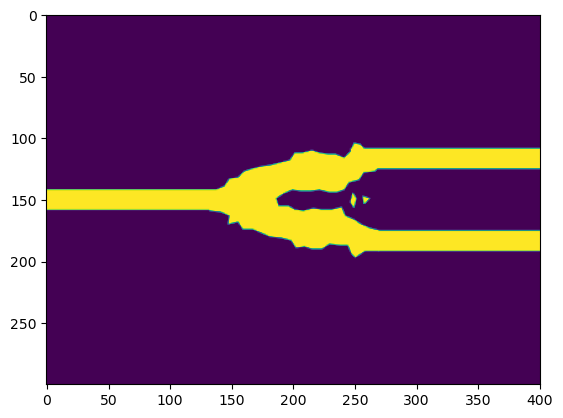

In [20]:
# Structure is the same as previous but with the polygon in the opt domain
eps_new = emopt.grid.StructuredMaterial2D(X, Y, dx, dy)
eps_new.add_primitive(out_wg1)
eps_new.add_primitive(out_wg2)
eps_new.add_primitive(in_wg)
eps_new.add_primitive(bg)
eps_plot = sim.eps.get_values_in(optdomain)

rmin = (optdomain.x[0], optdomain.y[0])
dr = (optdomain.dx, optdomain.dy)
polygons = get_contour(eps_plot, rmin, dr)
for p in polygons:
    p.material_value = eps_si
    p.layer = 1
    eps_new.add_primitive(p)

# add the materials as well as the sources (we already solved for them)
sim_new.set_materials(eps_new, mu)
sim_new.set_sources(mode, src_line, mindex)
sim_new.field_domains = [mode_line, full_field]
sim_new.build()

eps_plot = sim_new.eps.get_values_in(full_field)
plt.imshow(eps_plot.real)

In [21]:
class ShapeAM(AdjointMethodPNF2D):
    def __init__(self, sim, polygons, mode_match, mm_line, step=1e-8):
        super(ShapeAM, self).__init__(sim, step)

        self.polygons = polygons

        self.mode_match = mode_match
        self.mm_line = mm_line
        self.current_fom = 0.0

    def update_system(self, params):
        """Update the geometry of the system given a set of values for the
        design variables.

        The set of design variables (i.e. polygon verts) is given by:
            [x1,x2,...y1,y2,etc.], with polygons given in sequence

        Updating the structure involves modifying the x,y coordinates of our
        polygon.
        """
        # Update polygons
        p_start = 0
        for p in self.polygons:
            n = p.Np # number of verts in current polygon
            x = np.zeros(n)
            y = np.zeros(n)
            for i in range(p_start,p_start+n):
                x[i-p_start] = params[i]
                y[i-p_start] = params[i+n]
            p.set_points(x, y)
            p_start += 2*n

    @run_on_master
    def calc_f(self, sim, params):
        Hz, Ex, Ey = sim.saved_fields[0]
        self.mode_match.compute(Hz=Hz, Ex=Ex, Ey=Ey)
        fom = -self.mode_match.get_mode_match_forward(1.0)
        return fom

    @run_on_master
    def calc_dfdx(self, sim, params):
        dFdHz = np.zeros([sim.M, sim.N], dtype=np.complex128)
        dFdEx = np.zeros([sim.M, sim.N], dtype=np.complex128)
        dFdEy = np.zeros([sim.M, sim.N], dtype=np.complex128)

        # Get the fields which were recorded
        Hz, Ex, Ey = sim.saved_fields[0]

        self.mode_match.compute(Hz=Hz, Ex=Ex, Ey=Ey)

        dFdHz[self.mm_line.j, self.mm_line.k] = -self.mode_match.get_dFdHz()
        dFdEx[self.mm_line.j, self.mm_line.k] = -self.mode_match.get_dFdEx()
        dFdEy[self.mm_line.j, self.mm_line.k] = -self.mode_match.get_dFdEy()

        return (dFdHz, dFdEx, dFdEy)

    def calc_grad_p(self, sim, params):
        """Out figure of merit contains no additional non-field dependence on
        the design variables so we just return zeros here.

        See the AdjointMethod documentation for the mathematical details of
        grad y and to learn more about its use case.
        """
        return np.zeros(params.shape)

In [22]:
# define the shape optimization object
def opt_plot(params, sim, am, fom_hist):
    """Plot the current state of the optimization.

    This function is called after each iteration of the optimization
    """
    print('Finished iteration %d.' % (len(fom_hist)+1))
    current_fom = -1*am.calc_fom(sim, params)
    fom_hist.append(current_fom)
    foms = {'IL':fom_hist}

    Hz, Ex, Ey = sim.saved_fields[1]
    eps = sim.eps.get_values_in(sim.field_domains[1])

    emopt.io.plot_iteration(np.real(Hz), np.real(eps), sim.Xreal, sim.Yreal, foms,
                   fname='current_result.pdf')

s_am = ShapeAM(sim_new,
               polygons,
               mode_match,
               mode_line)

param_list = []
for p in polygons:
    param_list.append(p.xs)
    param_list.append(p.ys)
design_params = np.concatenate(param_list)
print(len(design_params))
#s_am.check_gradient(design_params)

# define a callback function which is executed after each iteration. This
# function saves a plot of the structure the desired field component, and
# the history of the figure of merit to a file called current_result.pdf
fom_list = []
callback = lambda x : opt_plot(x, sim, s_am, fom_list)

# setup and run the optimization!
opt = emopt.optimizer.Optimizer(s_am, design_params, tol=1e-5,
                                callback_func=callback, Nmax=15)
results = opt.run()

eps_plot = sim_new.eps.get_values_in(optdomain)
plt.imshow(eps_plot.real)


172
[INFO] Running forward solver...


KeyboardInterrupt: 